# install packages and import

In [ ]:
!pip install hazm
!pip install cleantext
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import required packages

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, ConfusionMatrixDisplay
from sklearn.utils import shuffle

from transformers import BertConfig, BertTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F

import hazm
from cleantext import clean

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import os
import re
import json
import copy
import collections


# Upload Snappfood dataset and load Data

In [ ]:
!unzip Snappfood-Dataset.zip

Archive:  Snappfood-Dataset.zip
   creating: Snappfood-Dataset/
  inflating: Snappfood-Dataset/dev.csv  
  inflating: Snappfood-Dataset/test.csv  
  inflating: Snappfood-Dataset/train.csv  


In [ ]:
def load_csv(file_path):
    data_df = pd.DataFrame(columns=['comment', 'label', 'label_id'])
    print(f'Loading {file_path}')
    with open(file_path) as f:
        for line in tqdm(f.readlines()[1:]):
            line = line.strip().replace('\t', ',').split(',')
            line = [part for part in line if len(part) != 0]
            if len(line) > 4:
                line[1:-2] = [' , '.join(line[1:-2])]

            data_df.loc[int(line[0])] = line[1:]

    print('Done.')
    return data_df


train_df = load_csv('Snappfood-Dataset/train.csv')
valid_df = load_csv('Snappfood-Dataset/dev.csv')
test_df = load_csv('Snappfood-Dataset/test.csv')

Loading Snappfood-Dataset/train.csv


  0%|          | 0/56700 [00:00<?, ?it/s]

Done.
Loading Snappfood-Dataset/dev.csv


  0%|          | 0/6300 [00:00<?, ?it/s]

Done.
Loading Snappfood-Dataset/test.csv


  0%|          | 0/7000 [00:00<?, ?it/s]

Done.


# Data Augmentation

In [ ]:
!pip install PersianNLPAug

import persiannlpaug.augmenter.char as pna

# Define augmenter
aug = pna.NoiseAug()

# Define a function to augment comments in a data frame
def augment_comments(df):
    # Create a copy of the data frame
    augmented_df = df.copy()

    # Augment comments
    for i, row in augmented_df.iterrows():
        comment = row['comment']
        augmented_comment = aug.augment(comment)
        augmented_df.at[i, 'comment'] = augmented_comment

    return augmented_df

# Load data frames
train_df = load_csv('Snappfood-Dataset/train.csv')
valid_df = load_csv('Snappfood-Dataset/dev.csv')

# Augment comments in the data frames
train_df = augment_comments(train_df)
valid_df = augment_comments(valid_df)

In [ ]:
valid_df['label'].unique()

array(['SAD', 'HAPPY'], dtype=object)

In [ ]:
label_to_id = {'SAD': 1, 'HAPPY': 0}
id_to_label = {0: 'HAPPY', 1: 'SAD'}

([<matplotlib.axis.XTick at 0x7f1f5b458af0>,
 [Text(0.05, 0, '0'), Text(0.95, 0, '1')])

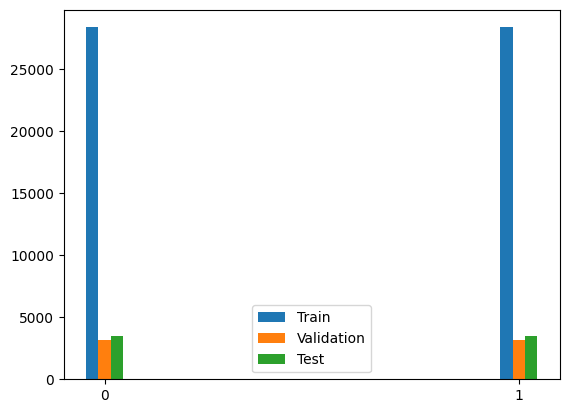

In [ ]:
plt.hist([train_df['label_id'], valid_df['label_id'], test_df['label_id']], label=['Train', 'Validation', 'Test'])
plt.legend()
plt.xticks([0.05, 0.95], id_to_label)

In [ ]:
train_df = train_df[['comment', 'label_id']]
valid_df = valid_df[['comment', 'label_id']]
test_df = test_df[['comment', 'label_id']]

# Preprocessing

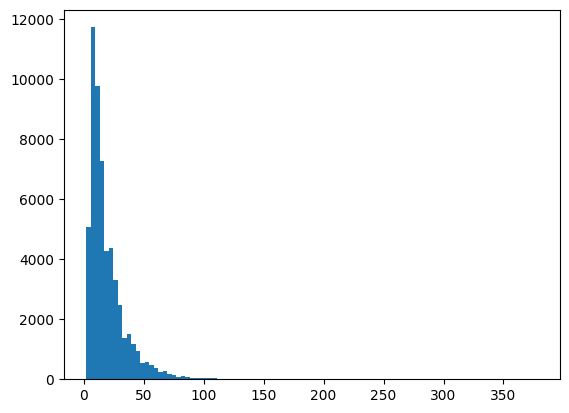

In [ ]:
def preprocess(data):
    data_preprocessed = data.copy()
    data_preprocessed['comment'] = data['comment'].apply(hazm.word_tokenize)
    data_preprocessed['comment_len'] = data_preprocessed['comment'].apply(len)

    plt.hist(data_preprocessed['comment_len'], bins=100)

preprocess(train_df)

In [ ]:
COMMENT_MAX_LEN=50

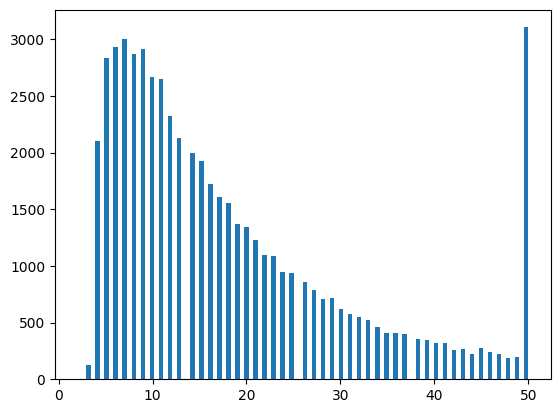

In [ ]:
def preprocess(data):
    data_preprocessed = data.copy()
    data_preprocessed['comment'] = data['comment'].apply(lambda x: hazm.word_tokenize(x)[:COMMENT_MAX_LEN])
    data_preprocessed['comment_len'] = data_preprocessed['comment'].apply(len)

    plt.hist(data_preprocessed['comment_len'], bins=100)

preprocess(train_df)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


In [ ]:
# general config
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16

CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased-sentiment-snappfood'
OUTPUT_PATH = '/content/bert-fa-base-uncased-sentiment-snappfood/pytorch_model.bin'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [ ]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)

In [ ]:
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label_to_id,
        'id2label': id_to_label,
    })

print(config.to_json_string())

{
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "finetuning_task": "snappfood",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "HAPPY",
    "1": "SAD"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "HAPPY": 0,
    "SAD": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.29.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}



In [ ]:
idx = np.random.randint(0, len(train_df))
sample_comment = train_df.iloc[idx]['comment']
sample_label = train_df.iloc[idx]['label_id']

print(f'Sample: \n{sample_comment}\n{sample_label}')

tokens = tokenizer.tokenize(sample_comment)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'  Comment: {sample_comment}')
print(f'   Tokens: {tokenizer.convert_tokens_to_string(tokens)}')
print(f'Token IDs: {token_ids}')


Sample: 
بسیار تازه و عالی بود سری قبل هم سفارش دادیم عالی بود دست تون درد نکنه
0
  Comment: بسیار تازه و عالی بود سری قبل هم سفارش دادیم عالی بود دست تون درد نکنه
   Tokens: بسیار تازه و عالی بود سری قبل هم سفارش دادیم عالی بود دست تون درد نکنه
Token IDs: [3177, 4923, 1379, 4392, 2834, 3593, 3556, 2820, 7785, 9247, 4392, 2834, 2910, 6789, 4892, 48449]


In [ ]:
encoding = tokenizer.encode_plus(
    sample_comment,
    max_length=COMMENT_MAX_LEN,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=True,
    return_attention_mask=True,
    padding='max_length',
    return_tensors='pt',  # Return PyTorch tensors
)

print(f'Keys: {encoding.keys()}\n')
for k in encoding.keys():
    print(f'{k}:\n{encoding[k]}')

Keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

input_ids:
tensor([[    2,  3177,  4923,  1379,  4392,  2834,  3593,  3556,  2820,  7785,
          9247,  4392,  2834,  2910,  6789,  4892, 48449,     4,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])
token_type_ids:
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])
attention_mask:
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])


In [ ]:
def preprocess(data):
    def cleaning(text):
        # regular cleaning
        normalizer = hazm.Normalizer()
        text_new = normalizer.normalize(text)

        wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)
    
        text = wierd_pattern.sub(r'', text)

        # removing extra spaces, hashtags
        text = re.sub("#", "", text)
        text = re.sub("\s+", " ", text)

        return text

    data['comment'] = data['comment'].apply(cleaning)
    return data
    
train_df = preprocess(train_df)
valid_df = preprocess(valid_df)
test_df = preprocess(test_df)

In [ ]:
test_df

,comment,label_id
0,خواهشا خواهشا خواهشا واسه ارسال شیرینیها یه فک...,0
1,غذا گرم رسید کیفیت و پخت گوشت عالی بود,0
2,قیمت سس شکلات روی بسته بندی ۱۵۰۰۰ بود ولی قیمت...,1
3,عکس توی پیج یه شیرینی شکری روشن رنگ هست که همم...,1
4,باز هم میگم، پیتزا نباید اینقد چرب باشه,1
...,...,...
6995,سطح پیتزا سوخته بود متاسفانه و ارزش اون پولو ن...,1
6996,بسته بندی خیلی بسیار بد شده,1
6997,سلام خسته نباشید همه چی خوب بود فقط یک مقدار م...,0
6998,غذا سرد و کیفیت قابل قبول نبود,1


# Dataloader

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
class SnappFoodDataset(Dataset):
    def __init__(self, tokenizer, dataframe):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        item = self.dataframe.iloc[idx]
        comment = item['comment']
        label = item['label_id']

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            max_length=COMMENT_MAX_LEN,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')
        
        return {
                'comment': comment,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'token_type_ids': encoding['token_type_ids'].flatten(),
                'lable': int(label),
                }

In [ ]:
train_dataset = SnappFoodDataset(tokenizer, train_df)
valid_dataset = SnappFoodDataset(tokenizer, valid_df)
test_dataset = SnappFoodDataset(tokenizer, test_df)

In [ ]:
test_dataset[2]

{'comment': 'قیمت سس شکلات روی بسته بندی ۱۵۰۰۰ بود ولی قیمت اعلامی در اسنپ ۱۸۰۰۰ بود. ۳۰۰۰ تومن تفاوت قیمت روی یک محصول خیلی زیاد است!',
 'input_ids': tensor([    2,  3377, 11186, 11255,  3040,  4341,  5936, 34020,  2834,  3362,
          3377, 12003,  2786, 10733, 48717,  2834,  1012, 12386, 42140,  5000,
          3377,  3040,  2829,  3573,  3805,  4216,  2806,  1001,     4,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]),
 'lable': 1}

In [ ]:
train_dataloder = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE)
valid_dataloder = DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE)
test_dataloder = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE)

# Pretrained Bert features

In [ ]:
bert = BertModel.from_pretrained('HooshvareLab/bert-fa-base-uncased-sentiment-snappfood')

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased-sentiment-snappfood were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
bert = bert.eval().to(device)

In [ ]:
bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(100000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
bert_outputs_train = torch.zeros(len(train_df), 768)
bert_outputs_valid = torch.zeros(len(valid_df), 768)
bert_outputs_test = torch.zeros(len(test_df), 768)

In [ ]:
# Training feature extraction
i = 0
for batch in tqdm(train_dataloder):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    token_type_ids = batch['token_type_ids'].to(device)
    with torch.no_grad():
        out = bert(input_ids, attention_mask, token_type_ids)['pooler_output'].cpu()
    bert_outputs_train[i: i + out.size(0)] = out
    i += out.size(0)

  0%|          | 0/3544 [00:00<?, ?it/s]

In [ ]:
# Validation feature extraction
i = 0
for batch in tqdm(valid_dataloder):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    token_type_ids = batch['token_type_ids'].to(device)
    with torch.no_grad():
        out = bert(input_ids, attention_mask, token_type_ids)['pooler_output'].cpu()
    bert_outputs_valid[i: i + out.size(0)] = out
    i += out.size(0)

  0%|          | 0/394 [00:00<?, ?it/s]

In [ ]:
# Test feature extraction
i = 0
for batch in tqdm(test_dataloder):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    token_type_ids = batch['token_type_ids'].to(device)
    with torch.no_grad():
        out = bert(input_ids, attention_mask, token_type_ids)['pooler_output'].cpu()
    bert_outputs_test[i: i + out.size(0)] = out
    i += out.size(0)

  0%|          | 0/438 [00:00<?, ?it/s]

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
bert_outputs_train = bert_outputs_train.numpy()
bert_outputs_valid = bert_outputs_valid.numpy()
bert_outputs_test = bert_outputs_test.numpy()

In [ ]:
dimentin_reduction = PCA(n_components=2)
bert_outputs_train_2d = dimentin_reduction.fit_transform(bert_outputs_train)
bert_outputs_valid_2d = dimentin_reduction.transform(bert_outputs_valid)
bert_outputs_test_2d = dimentin_reduction.transform(bert_outputs_test)

In [ ]:
train_df['label_id']

0        1
1        0
2        1
3        0
4        0
        ..
56695    0
56696    0
56697    0
56698    0
56699    1
Name: label_id, Length: 56700, dtype: object

In [ ]:
y_train = train_df['label_id'].astype(int)
y_valid = valid_df['label_id'].astype(int)
y_test = test_df['label_id'].astype(int)

Text(0.5, 1.0, 'Train data')

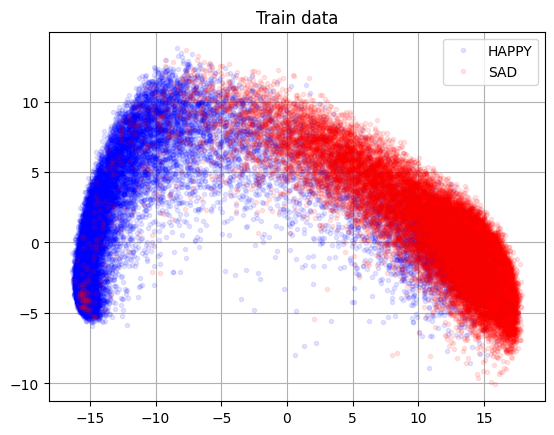

In [ ]:
plt.plot(bert_outputs_train_2d[y_train == 0, 0], bert_outputs_train_2d[y_train == 0, 1], 'b.', alpha=0.1, label='HAPPY')
plt.plot(bert_outputs_train_2d[y_train == 1, 0], bert_outputs_train_2d[y_train == 1, 1], 'r.', alpha=0.1, label='SAD')
plt.grid()
plt.legend()
plt.title('Train data')

Text(0.5, 1.0, 'Validation data')

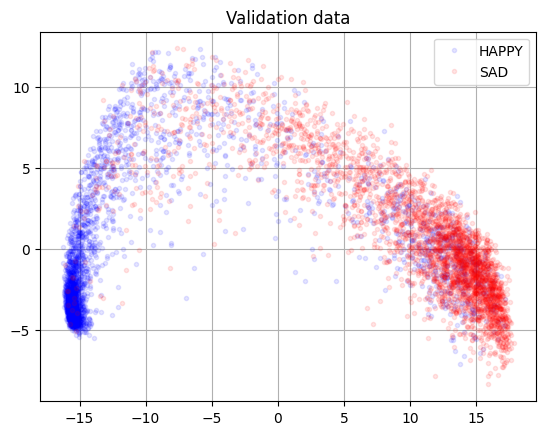

In [ ]:
plt.plot(bert_outputs_valid_2d[y_valid == 0, 0], bert_outputs_valid_2d[y_valid == 0, 1], 'b.', alpha=0.1, label='HAPPY')
plt.plot(bert_outputs_valid_2d[y_valid == 1, 0], bert_outputs_valid_2d[y_valid == 1, 1], 'r.', alpha=0.1, label='SAD')
plt.grid()
plt.legend()
plt.title('Validation data')

Text(0.5, 1.0, 'Test data')

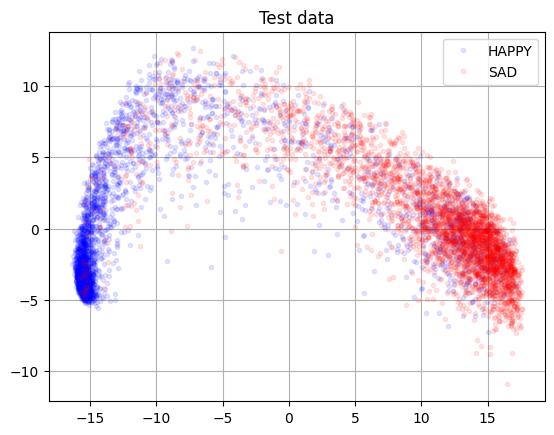

In [ ]:
plt.plot(bert_outputs_test_2d[y_test == 0, 0], bert_outputs_test_2d[y_test == 0, 1], 'b.', alpha=0.1, label='HAPPY')
plt.plot(bert_outputs_test_2d[y_test == 1, 0], bert_outputs_test_2d[y_test == 1, 1], 'r.', alpha=0.1, label='SAD')
plt.grid()
plt.legend()
plt.title('Test data')

# Train classifier on Bert outputs

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
clf = LogisticRegression()
clf.fit(bert_outputs_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
h_train = clf.predict_proba(bert_outputs_train)
h_valid = clf.predict_proba(bert_outputs_valid)
h_test = clf.predict_proba(bert_outputs_test)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [ ]:
print('Accuracy:')

print('Train: ', accuracy_score(y_train, h_train[:, 1] > 0.5))
print('Valid: ', accuracy_score(y_valid, h_valid[:, 1] > 0.5))
print('Test: ', accuracy_score(y_test, h_test[:, 1] > 0.5))

Accuracy:
Train:  0.9525573192239859
Valid:  0.8553968253968254
Test:  0.8677142857142857


In [ ]:
print('F1-score:')

print('Train: ', f1_score(y_train, h_train[:, 1] > 0.5))
print('Valid: ', f1_score(y_valid, h_valid[:, 1] > 0.5))
print('Test: ', f1_score(y_test, h_test[:, 1] > 0.5))

F1-score:
Train:  0.9530590165078701
Valid:  0.8575449569976544
Test:  0.8689127972819932


In [ ]:
print('ROC AUC:')

print('Train: ', roc_auc_score(y_train, h_train[:, 1]))
print('Valid: ', roc_auc_score(y_valid, h_valid[:, 1]))
print('Test: ', roc_auc_score(y_test, h_test[:, 1]))

ROC AUC:
Train:  0.9882107275832144
Valid:  0.9290337112622827
Test:  0.9341915102040816


# Build model

In [ ]:
from transformers.pipelines import zero_shot_classification
class SnappFoodModel(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, 1)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        z = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids)
        
        pooled_output = self.dropout(z['pooler_output'])
        out = self.classifier(pooled_output)
        return out 

In [ ]:
sf_model = SnappFoodModel(config=config)
sf_model = sf_model.to(device)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased-sentiment-snappfood were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
sf_model

SnappFoodModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

# Train model

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [ ]:
def score_model(y_true, y_pred):
    # y_pred after sigmoid
    return {'acc': accuracy_score(y_true, y_pred > 0),
            'f1-score': f1_score(y_true, y_pred > 0),
            'roc-auc': roc_auc_score(y_true, y_pred)
    }

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, epochs, valid_steps=1000):
    train_history = {'loss': [], 'accuracy': [], 'f1-score': [], 'roc-auc': []}
    valid_history = {'loss': [], 'accuracy': [], 'f1-score': [], 'roc-auc': []}
    
    for e in range(epochs):
        sum_loss_train = 0
        sum_acc_train = 0
        sum_f1_train = 0
        sum_roc_train = 0
        train_steps = 0
        model.train()
        for batch in tqdm(dataloaders['train']):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            label = batch['lable'].to(device).view(-1, 1).float()

            optimizer.zero_grad()
            output = model(input_ids, attention_mask, token_type_ids)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            sum_loss_train += loss.item()
            output = nn.functional.sigmoid(output.detach())
            metrics = score_model(label.cpu().numpy(), output.cpu().numpy())
            sum_acc_train += metrics['acc']
            sum_f1_train += metrics['f1-score']
            sum_roc_train += metrics['roc-auc']
            train_steps += 1

            if train_steps % valid_steps == 0:
                print('Validation...')
                sum_loss_valid = 0
                sum_acc_valid = 0
                sum_f1_valid = 0
                sum_roc_valid = 0
                validation_steps = 0
                model.eval()
                for batch in tqdm(dataloaders['valid']):
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    token_type_ids = batch['token_type_ids'].to(device)
                    label = batch['lable'].to(device).view(-1, 1).float()

                    with torch.no_grad():
                        output = model(input_ids, attention_mask, token_type_ids)
                        loss = criterion(output, label)
                        
                        sum_loss_valid += loss.item()
                        output = nn.functional.sigmoid(output)
                        metrics = score_model(label.cpu().numpy(), output.cpu().numpy())
                        sum_acc_valid += metrics['acc']
                        sum_f1_valid += metrics['f1-score']
                        sum_roc_valid += metrics['roc-auc']
                        validation_steps += 1

                train_history['loss'].append(sum_loss_train / train_steps)
                train_history['accuracy'].append(sum_acc_train / train_steps)
                train_history['f1-score'].append(sum_f1_train / train_steps)
                train_history['roc-auc'].append(sum_roc_train / train_steps)

                valid_history['loss'].append(sum_loss_valid / validation_steps)
                valid_history['accuracy'].append(sum_acc_valid / validation_steps)
                valid_history['f1-score'].append(sum_f1_valid / validation_steps)
                valid_history['roc-auc'].append(sum_roc_valid / validation_steps)
                
                sum_loss_train = 0
                sum_acc_train = 0
                sum_f1_train = 0
                sum_roc_train = 0
                train_steps = 0

    return model, train_history, valid_history

In [ ]:
# Part1, training classifier

dataloders = {
    'train': train_dataloder,
    'valid': valid_dataloder
}

criterion = nn.BCEWithLogitsLoss()
sf_model.bert.requires_grad_ = False
optimizer = torch.optim.Adam(sf_model.classifier.parameters() ,lr=0.001)

sf_model, history_train, history_valid = train_model(sf_model, dataloders, criterion, optimizer, epochs=5)

  0%|          | 0/3544 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/3544 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/3544 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/3544 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/3544 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Loss')

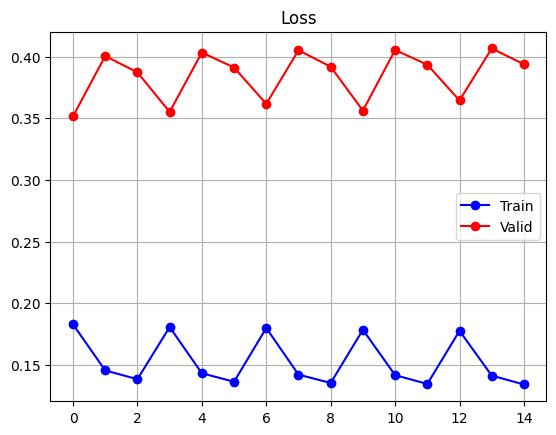

In [ ]:
plt.plot(history_train['loss'], 'bo-', label='Train')
plt.plot(history_valid['loss'], 'ro-', label='Valid')
plt.grid()
plt.legend()
plt.title('Loss')

Text(0.5, 1.0, 'Accuracy')

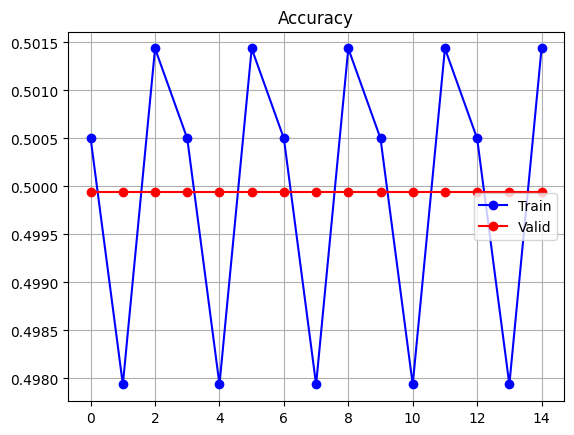

In [ ]:
plt.plot(history_train['accuracy'], 'bo-', label='Train')
plt.plot(history_valid['accuracy'], 'ro-', label='Valid')
plt.grid()
plt.legend()
plt.title('Accuracy')

Text(0.5, 1.0, 'F1-score')

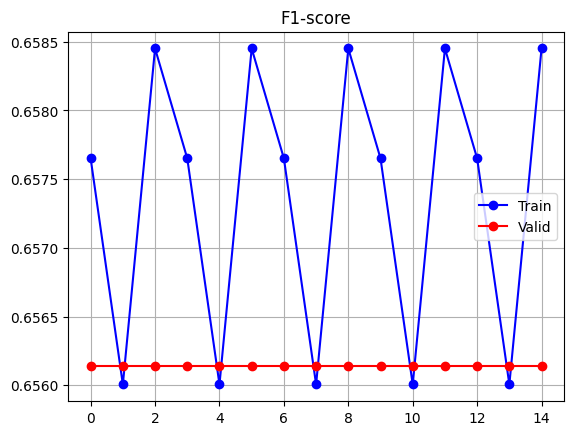

In [ ]:
plt.plot(history_train['f1-score'], 'bo-', label='Train')
plt.plot(history_valid['f1-score'], 'ro-', label='Valid')
plt.grid()
plt.legend()
plt.title('F1-score')

Text(0.5, 1.0, 'ROC-AUC')

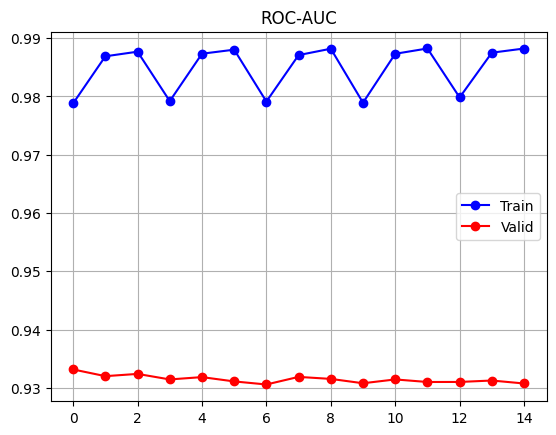

In [ ]:
plt.plot(history_train['roc-auc'], 'bo-', label='Train')
plt.plot(history_valid['roc-auc'], 'ro-', label='Valid')
plt.grid()
plt.legend()
plt.title('ROC-AUC')

In [ ]:
# Part2, finetuning

dataloders = {
    'train': train_dataloder,
    'valid': valid_dataloder
}

criterion = nn.BCEWithLogitsLoss()
sf_model.bert.requires_grad_ = True
optimizer = torch.optim.Adam(sf_model.parameters() ,lr=0.00001)

sf_model, history_train, history_valid = train_model(sf_model, dataloders, criterion, optimizer, epochs=5)

  0%|          | 0/3544 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/3544 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/3544 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/3544 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/3544 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Loss')

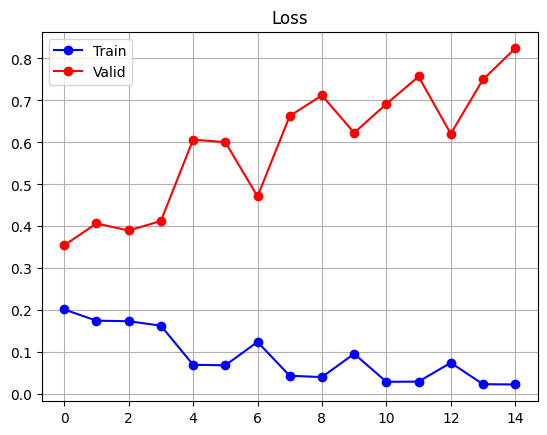

In [ ]:
plt.plot(history_train['loss'], 'bo-', label='Train')
plt.plot(history_valid['loss'], 'ro-', label='Valid')
plt.grid()
plt.legend()
plt.title('Loss')

Text(0.5, 1.0, 'Accuracy')

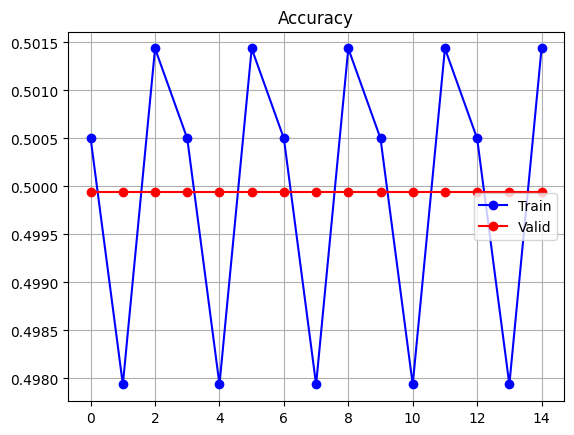

In [ ]:
plt.plot(history_train['accuracy'], 'bo-', label='Train')
plt.plot(history_valid['accuracy'], 'ro-', label='Valid')
plt.grid()
plt.legend()
plt.title('Accuracy')

Text(0.5, 1.0, 'F1-score')

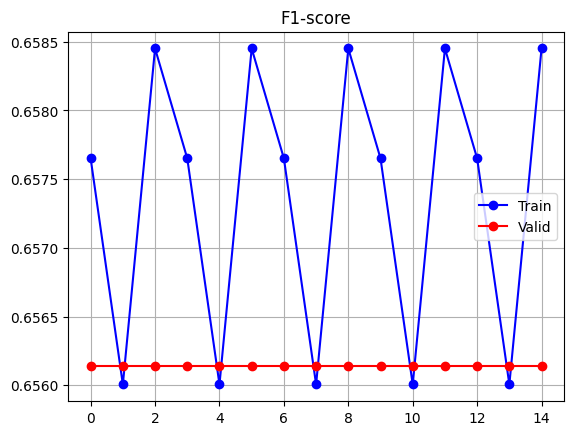

In [ ]:
plt.plot(history_train['f1-score'], 'bo-', label='Train')
plt.plot(history_valid['f1-score'], 'ro-', label='Valid')
plt.grid()
plt.legend()
plt.title('F1-score')

Text(0.5, 1.0, 'ROC-AUC')

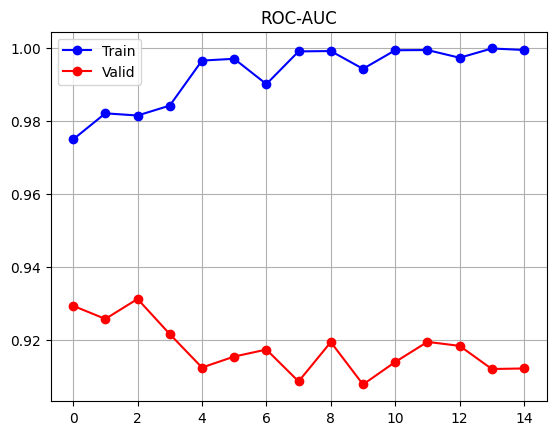

In [ ]:
plt.plot(history_train['roc-auc'], 'bo-', label='Train')
plt.plot(history_valid['roc-auc'], 'ro-', label='Valid')
plt.grid()
plt.legend()
plt.title('ROC-AUC')

# Final Test

# Predictions

In [ ]:
id_to_label

{0: 'HAPPY', 1: 'SAD'}

In [ ]:
df_error_analysis = test_df.copy()

In [ ]:
df_error_analysis['SAD prediction'] = h_test[:, 1]

In [ ]:
df_error_analysis

,comment,label_id,SAD prediction
0,خواهشا خواهشا خواهشا واسه ارسال شیرینیها یه فک...,1,0.980126
1,غذا گرم رسید کیفیت و پخت گوشت عالی بود,0,0.006229
2,قیمت سس شکلات روی بسته بندی ۱۵۰۰۰ بود ولی قیمت...,1,0.095791
3,عکس توی پیج یه شیرینی شکری روشن رنگ هست که همم...,1,0.977318
4,باز هم میگم، پیتزا نباید اینقد چرب باشه,1,0.887839
...,...,...,...
6995,سطح پیتزا سوخته بود متاسفانه و ارزش اون پولو ن...,1,0.983609
6996,بسته بندی خیلی بسیار بد شده,1,0.894100
6997,سلام خسته نباشید همه چی خوب بود فقط یک مقدار م...,0,0.015974
6998,غذا سرد و کیفیت قابل قبول نبود,1,0.992492


In [ ]:
df_error_analysis_SAD = df_error_analysis[df_error_analysis['label_id'] == '1']
df_error_analysis_SAD = df_error_analysis_SAD.sort_values('SAD prediction')

df_error_analysis_HAPPY = df_error_analysis[df_error_analysis['label_id'] == '0']
df_error_analysis_HAPPY = df_error_analysis_HAPPY.sort_values('SAD prediction', ascending=False)

In [ ]:
df_error_analysis_SAD

,comment,label_id,SAD prediction
4328,عالی بود پیشنهاد میکنم,1,0.001961
4234,عذم ارسال کوپن پوره سیب زمینی توسط گاردن گریل,1,0.002352
797,درود بر شما حجم پیتزا خوب بود. یک مقدار از پیت...,1,0.002393
6878,کیفیت خییییییلی عاااالی بود، خوش طعم، ترد و خو...,1,0.002627
4614,در توضیحات، نوشته بود شربت گل رز، اما درواقع س...,1,0.002780
...,...,...,...
875,۲ ساعت طول کشید بیاد. ۳ بار تاخیر داشت. واقعا ...,1,0.999704
2743,پیتزایی بد مزه با بوی بد مرغ و سیب زمینی خام و...,1,0.999710
2153,یک عدد بربری مصنوعی (پلاستیکی) بود حاوی برخی م...,1,0.999712
3982,بد مزه‌ترین ساندویچ مرغی بود که تو زندگیم خورد...,1,0.999773


In [ ]:
for i in range(50):
    row = df_error_analysis_SAD.iloc[i]
    print(row['comment'])
    print(id_to_label[int(row['label_id'])])
    print(f'Model prediction probablity of beeing SAD: {100 * row["SAD prediction"]:f} %')
    print('\n----------------------------------------------------\n')

عالی بود پیشنهاد میکنم
SAD
Model prediction probablity of beeing SAD: 0.196099 %

----------------------------------------------------

عذم ارسال کوپن پوره سیب زمینی توسط گاردن گریل
SAD
Model prediction probablity of beeing SAD: 0.235244 %

----------------------------------------------------

درود بر شما حجم پیتزا خوب بود. یک مقدار از پیتزای شما بسیار تلخ بود! به نظرم اصلا نباید یک اشکال این‌چنینی رخ بدهد حیف است.
SAD
Model prediction probablity of beeing SAD: 0.239338 %

----------------------------------------------------

کیفیت خییییییلی عاااالی بود، خوش طعم، ترد و خوشمزه خیلی هم سریع به دستم رسید و کاملا گرم بود ممنون
SAD
Model prediction probablity of beeing SAD: 0.262728 %

----------------------------------------------------

در توضیحات، نوشته بود شربت گل رز، اما درواقع سیروپ بود، ممنون که خیلی زود رسیدگی کردن و امدن رایگان، پس گرفتن و اعتبارش امد توحسابمون، فقط یه نکته دیگه، باید به تاریخ‌ها دقت کرد، مثلا ماچهارتاپنیر سفارش دادیم اماوقتی اوردن دیدیم تاریخش فقط تااخر همین ماهه.

In [ ]:
for i in range(50):
    row = df_error_analysis_HAPPY.iloc[i]
    print(row['comment'])
    print(id_to_label[int(row['label_id'])])
    print(f'Model prediction probablity of beeing SAD: {100 * row["SAD prediction"]:f} %')
    print('\n----------------------------------------------------\n')

غذا سرد و بی طعم تیکه‌های سوسیس خام بودن برند سس تک نفره هاشم ناشناخته و بیطعم
HAPPY
Model prediction probablity of beeing SAD: 99.954894 %

----------------------------------------------------

با این که تو نظرات خونده بودم جوجه کباب با استخون معمولا سوخته تحویل میشه.. اما سفارش دادم تا تست کنم.. به طرز عجیبی سوخته بود و مزه تلخی داشت این اولین سفارشم از این رستوران که اینقدر نا راضیم جوجه بدون استخوان خوب بود مثل همیشه
HAPPY
Model prediction probablity of beeing SAD: 99.947395 %

----------------------------------------------------

متاسفانه چنجه خوب نپخته بود و مغزپخت نشده بود. و در کمال تعجب، در کنار خوراک لقمه ۳-۴ تیکه نان سنگک خشک گذاشته بودن. یعنی نان خشکی که مثل سنگ سفت بود و اندازه‌ی هرکدوم اندازه یه کف دست بود …
HAPPY
Model prediction probablity of beeing SAD: 99.892006 %

----------------------------------------------------

معمولی با یه خمیر پ-ن-و یه لایه نازک مواد
HAPPY
Model prediction probablity of beeing SAD: 99.885957 %

------------------------------------------------

In [ ]:
df_error_analysis_HAPPY[df_error_analysis_HAPPY['SAD prediction'] > 0.9]

,comment,label_id,SAD prediction
672,غذا سرد و بی طعم تیکه‌های سوسیس خام بودن برند ...,0,0.999549
483,با این که تو نظرات خونده بودم جوجه کباب با است...,0,0.999474
1489,متاسفانه چنجه خوب نپخته بود و مغزپخت نشده بود....,0,0.998920
1867,معمولی با یه خمیر پ-ن-و یه لایه نازک مواد,0,0.998860
6453,slm khob bod faghat kamtaraz tedadi bod ke zad...,0,0.998570
...,...,...,...
3027,سلام درخواست برای بنده اشتباها اضافه‌تر ارسال ...,0,0.904489
89,برای دومین بار، سوپرچیزفرایز چنگال نداشت و امک...,0,0.904105
1007,به جای لوبیا پلو، عدس پلو فرستادند,0,0.901463
966,به تاریخ انقضاء چیپس‌ها فقط ۱۵ روز مانده است ک...,0,0.900803


In [ ]:
test_df.loc[df_error_analysis_HAPPY[df_error_analysis_HAPPY['SAD prediction'] > 0.9].index, 'label_id'] = 1

In [ ]:
y_train = train_df['label_id'].astype(int)
y_valid = valid_df['label_id'].astype(int)
y_test = test_df['label_id'].astype(int)

In [ ]:
test_df.to_csv('test_fixed.csv')

In [ ]:
for i in range(50):
    row = df_error_analysis_SAD.iloc[i]
    print(row['comment'])
    print(id_to_label[int(row['label_id'])])
    print(f'Model prediction probablity of beeing SAD: {100 * row["SAD prediction"]:f} %')
    print('\n----------------------------------------------------\n')

عالی بود پیشنهاد میکنم
SAD
Model prediction probablity of beeing SAD: 0.196099 %

----------------------------------------------------

عذم ارسال کوپن پوره سیب زمینی توسط گاردن گریل
SAD
Model prediction probablity of beeing SAD: 0.235244 %

----------------------------------------------------

درود بر شما حجم پیتزا خوب بود. یک مقدار از پیتزای شما بسیار تلخ بود! به نظرم اصلا نباید یک اشکال این‌چنینی رخ بدهد حیف است.
SAD
Model prediction probablity of beeing SAD: 0.239338 %

----------------------------------------------------

کیفیت خییییییلی عاااالی بود، خوش طعم، ترد و خوشمزه خیلی هم سریع به دستم رسید و کاملا گرم بود ممنون
SAD
Model prediction probablity of beeing SAD: 0.262728 %

----------------------------------------------------

در توضیحات، نوشته بود شربت گل رز، اما درواقع سیروپ بود، ممنون که خیلی زود رسیدگی کردن و امدن رایگان، پس گرفتن و اعتبارش امد توحسابمون، فقط یه نکته دیگه، باید به تاریخ‌ها دقت کرد، مثلا ماچهارتاپنیر سفارش دادیم اماوقتی اوردن دیدیم تاریخش فقط تااخر همین ماهه.

# Finding best threshold

In [ ]:
thresholds = np.arange(0, 1.001, 0.01)
f1s_train = []
f1s_valid = []
f1s_test = []
for th in tqdm(thresholds):
    f1s_train.append(f1_score(y_train, h_train[:, 1] > th))
    f1s_valid.append(f1_score(y_valid, h_valid[:, 1] > th))
    f1s_test.append(f1_score(y_test, h_test[:, 1] > th))

  0%|          | 0/101 [00:00<?, ?it/s]

In [ ]:
f1s_train = np.array(f1s_train)
f1s_valid = np.array(f1s_valid)
f1s_test = np.array(f1s_test)

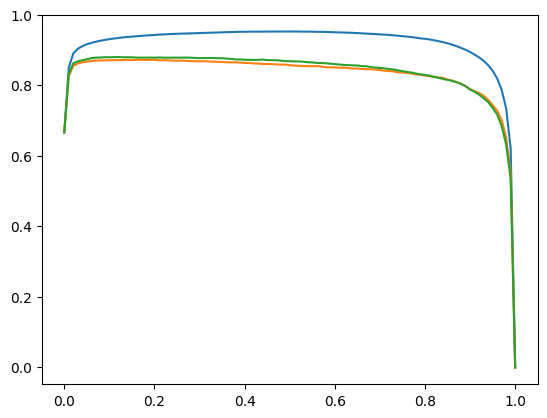

In [ ]:
plt.plot(thresholds, f1s_train, label='Train')
plt.plot(thresholds, f1s_valid, label='Valid')
plt.plot(thresholds, f1s_test, label='Test')

In [ ]:
th = thresholds[f1s_valid.argmax()]
print(th)

0.2


In [ ]:
print('ROC AUC:')

print('Train: ', roc_auc_score(y_train, h_train[:, 1]))
print('Valid: ', roc_auc_score(y_valid, h_valid[:, 1]))
print('Test: ', roc_auc_score(y_test, h_test[:, 1]))

ROC AUC:
Train:  0.9882107275832144
Valid:  0.9290337112622827
Test:  0.9745272083031098


In [ ]:
print('Accuracy:')

print('Train: ', accuracy_score(y_train, h_train[:, 1] > th))
print('Valid: ', accuracy_score(y_valid, h_valid[:, 1] > th))
print('Test: ', accuracy_score(y_test, h_test[:, 1] > th))

Accuracy:
Train:  0.9407936507936508
Valid:  0.8644444444444445
Test:  0.9122857142857143


In [ ]:
print('F1-score:')

print('Train: ', f1_score(y_train, h_train[:, 1] > th))
print('Valid: ', f1_score(y_valid, h_valid[:, 1] > th))
print('Test: ', f1_score(y_test, h_test[:, 1] > th))

F1-score:
Train:  0.9433427283927698
Valid:  0.8728409767718879
Test:  0.9200520833333332
